## Introduction to Monte Carlo Methods

### References

[Beginning Bayesian Statistics](https://pubs.er.usgs.gov/publication/70204463)

[Hamiltonian Monte Carlo in Python](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)

[Betancourt HMC - Best introduction to HMC](https://www.youtube.com/watch?v=VnNdhsm0rJQ)

[NUTS paper](http://arxiv.org/abs/1111.4246)

[HMC Tuning by Colin Caroll](https://colcarroll.github.io/hmc_tuning_talk/)


### What is a Monte Carlo simulation?

Monte Carlo simulations refer to any set of simulations that samples a lot of values from some distribution to estimate this distribution. 

### Why do we need it?

Earlier we saw the use of conjugate solutions to compute the posterior distribution directly. A lot of the times closed form solutions are not available, and we have to resort to discretization and quadrature rules to evaluate these posterior distributions. There are times when even this isn't feasible. In these situations, we resort to sampling from the posterior to estimate the distribution.

We look at three specific algorithms here:

1. Metropolis 
2. Metropolis-Hastings
3. Gibbs Sampling

A fourth one, the Hamiltonian Monte Carlo algorithm based on Hamiltonian mechanics is briefly illustrated here.

### Building blocks

#### Markov Chains

[Intuitive explanation of Markov Chains](https://brilliant.org/wiki/markov-chains/)

* A Markov chain is a stochastic system that transitions from one state to another based on a probability. For e.g. the position and velocity of a moving car could be the variables at times \\(t_0, t_1..t_n\\) at states given by \\(S_0, S_1...S_n\\). This is illustrated in the figure below. 

* The probability of moving to a new state is independent of how one reached the current state, i.e. the probability of moving to a new state only depends on the current state and the transition probability to the new state. To rephrase, one transitions from state \\(S_{t-1}\\) to state \\(S_{t}\\) based upon the transition probability given by the conditional probability\\(P(S_t | S_{t-1})\\). 

* We can also make observations at each state indicated by the observation nodes. In the example, the recordings using a radar (possibly noisy) at each state would be the observations.

* An absorbing state is one where the probability of staying at that state is 1, i.e. there is zero chance of leaving that state. A recurring state is one where there is a finite probability of returning to that state.

* If the state variables are discrete the model is called a Hidden Markov Model. 

![Markov Model](https://courseraimages.s3-us-west-2.amazonaws.com/MM.png)


#### Stationary distributions

*Reference* [Youtube](https://www.youtube.com/watch?v=aIdTGKjQWjA)

Stationary distributions simply mean that the probability of the distribution at a time t+1 is the same as that at time t. Using the terminology from the above section, the transition probability is the same for all t. Ergodic distributions are therefore stationary.

#### Ergodicity

Ergodicity is a critical property for a Markov Chain which combine the properties of a state being recurrent and aperiodic. Recurrent implies that, in a transition, a given state will return to itself. An aperiodic state returns to itself in a number of steps 1,2,3.... $\infty$. The implications of ergodicity are 

1. If we sample a space long enough we will cover almost every point in that space (theoretically). 

2. If we obtain a statistic from a sequence such as the mean, this statistic should be the same if we recompute it using a different sequence drawn from the same set of events. The implication here is that there is only one distribution unlike a non-stationary distribution which has an infinite set of PDFs. 


### Why does this work?

Suppose there is a system with three states given by A,B and C and there is a person who can transition from A \\(\longleftrightarrow\\) B \\(\longleftrightarrow\\) C with transition probabilities given by \\(p_{AB}\\), \\(p_{BC}\\) for transitioning to the right and \\(p_{BA}\\), \\(p_{CB}\\) for transitioning to the left. *The gist of the MCMC process is that the ratio of the transition probabilities of the two states equals the relative probabilities of the two states in the distribution*. 

Let us consider state B and the transition to state C. 

* The probability of moving to state C is given by the product of the probability of choosing C (since B can move to either A or C) and the probability of accepting the move to C given by \\(min(\dfrac{P_C}{P_B},1)\\). 

* The last part of accepting the proposed move is the interesting part, we decide to move depending on the ratio of the probability densities \\(P_C\\) and \\(P_B\\). The transition probability from B to C can therefore be written as 

$$p_{BC} = 0.5 \cdot min(\dfrac{P_C}{P_B},1)$$

* The transition probability from C to B can be similarly written as 

$$ p_{CB} = 0.5 \cdot min(\dfrac{P_B}{P_C},1)$$

* If we take the ratio of these probabilities

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{0.5 \cdot min(\dfrac{P_C}{P_B},1)}{0.5 \cdot min(\dfrac{P_B}{P_C},1)}$$

* If $P_C$ > $P_B$ we get 

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{P_C}{P_B}$$

* If \\(P_B > P_C\\), we still obtain the same term as a result of the min() function

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{P_C}{P_B}$$

Hence, the ratio of the transition probabilities between states can be seen as the ratio of their probability densities. In other words, if we run this experiment long enough where our volunteer has agreed to move between the states based on the transition probabilities, the adjacent positions are visited a number of times that is proportional to their relative probability densities in the target distribution. We can extend this argument for all points to suggest that if we run the experiment long enough, we can build the target distribution.


#### Proposal distribution
An easy to sample distribution such as a Gaussian distribution $q(x)$ such that 

$$q(x_{i+1} | x_{i}) \sim N(\mu, \sigma)$$

### The Bayesian Inference Process

1. Obtain the data and inspect it for a high-level understanding of the distribution of the data and the outliers
2. Define a reasonable prior for the data based on (1) and your understanding of the problem
3. Define a likelihood distribution for the data and obtain the likelihood of the data given this likelihood distribution
4. Obtain the posterior distribution using (2) and (3) by applying the Bayes Theorem

### The Metropolis Algorithm

#### Problem Statement

We start off by modeling a discrete number of events using a Poisson distribution shown below. 

$$f(x) = e^{-\mu} \mu^x / x!$$

The mean rate is represented by μ and x is positive integer that represents the number of events that can happen. If you recall from the discussion of the binomial distribution, that can also be used to model the probability of the number of successes out of 'n' trials. The Poisson distribution is a special case of this binomial distribution and is used when the trials far exceed the number of successes.

If our observed data has a Poisson likelihood distribution, using a Gamma prior for \\(\mu\\) results in a Gamma posterior distribution. 

#### Outline of the Metropolis algorithm
*What do we want to compute?*

To estimate a distribution of a parameter $\mu$

*What do we have available?*

Observed data

*How do we do it?*

1. Start with a parameter sample $\mu_{current}$ that is drawn from a distribution
2. Draw a second parameter sample $\mu_{proposed}$ from a proposal distribution
3. Compute the likelihood of the data for both the parameters
4. Compute the prior probability density of both the parameters
5. Compute the posterior probability density of both parameters by multiplying the prior and the likelihood from (3) and (4)
6. Select one parameter from the posterior probability density computed above using a rule and save the selected one as $\mu_{current}$ 
7. Repeat steps (2) to (7) till a large number of parameters have been drawn (usually around 5000, but this really depends on the problem)
8. Compute the distribution of the parameter $\mu$ by plotting a histogram of the saved sampled parameter $\mu_{current}$ in step (6)

#### The details

##### Notes

* I am leaving the hyperparameters and data undefined to make it easier to track and follow the sampled parameter values in these equations.

* We are assuming that we have a single data point 'x' to keep this easier to understand. This implies that the number of data points given by 'n' = 1.

<hr style = "border:1px dotted salmon"></hr>

1. Propose a single plausible value for our parameter $\mu$. This is $\mu_{current}$, and it is also called the current value. Let us assume that this is 7.5 for now.

<hr style = "border:1px dotted salmon"></hr>

2. Compute the prior probability density of getting \\(\mu = 7.5\\). We stated earlier in our example that we have selected a Gamma prior distribution for our parameter $\mu$.

   $$Gamma(\mu=7.5 |\alpha, \beta) = \beta^{\alpha} \mu^{\alpha - 1} e^{-\beta \mu} / \gamma(\alpha) = \beta^{\alpha} 7.5^{\alpha - 1} e^{-\beta 7.5} / \gamma(\alpha)$$

    
3. Compute the likelihood of the data 'x', given the parameter value of 7.5.  The likelihood distribution was a Poisson distribution in our example and is given by

   $$Poisson(x | \mu=7.5) = e^{-\mu} \mu^x / x! = e^{-7.5} 7.5^x / x!$$


4. Compute the posterior density from (2) and (3), we skip the denominator here since we are only going to make comparisons and the denominator is a constant. 

   $$Posterior\; density \propto Prior \cdot Likelihood $$
   
   The Gamma distribution is parameterized by the shape parameter $\alpha$ and the rate parameter $\beta$. If the prior distribution for the mean parameter $\mu$ is given by a Gamma distribution parameterized by $\alpha_{prior}$ and $\beta_{prior}$ and given 'n' observations (In our example, n = 1)

   $$\alpha_{posterior} = \alpha_{prior} + \sum_{i=0}^n x_i$$

   $$\beta_{posterior} = \beta_{prior} + n$$

<hr style = "border:1px dotted salmon"></hr>

5. Propose a second value for $\mu$, called $\mu_{proposed}$, which is drawn from a distribution called a proposal distribution centered on $\mu_{current}$. This value is called the proposed value. For the Metropolis algorithm, it has to be a symmetrical distribution. We will use a normal distribution for this example and set the mean of this proposal distribution to be the current value of $\mu$ or $\mu_{current}$. The standard deviation of the proposal distribution is a hyperparameter called the tuning parameter. Let us assume that we draw a value of 8.5 for $\mu_{proposed}$.

6. Compute the prior, likelihood and the posterior for this proposed value of $\mu$ or $\mu_{proposed}$ as we did in step (2), (3) and (4).

<hr style = "border:1px dotted salmon"></hr>

7. Select one value from the current and the proposed value with the following two steps (this step is where the Metropolis algorithm differs from the Metropolis-Hastings algorithm)  

   a. Compute the probability of moving to the proposed value as
   
      $$p_{move} = min( \dfrac{P(\mu_{proposed} | data)}{P(\mu_{current} | data)}, 1)$$

      Here $p_{move}$ is the minimum of the values given by the ratio of the posterior probabilities of \\(\mu_{proposed}\\) and \\(\mu_{current}\\), and the number 1. This caps the probability $p_{move}$ at 1 if the ratio happens to be greater than 1. $P_{move}$ is also referred to as the transition kernel.

   b. Draw a sample from a uniform distribution U(0,1). If $p_{move}$ from (a) above is greater than this number drawn from the uniform distribution, we accept the proposed value $\mu_{proposed}$. What this means is that if the posterior density of the proposed parameter value is greater than the posterior density of the current parameter value, then we move to the proposed value otherwise we probabilistically accept the proposed value based on the value of $p_{move}$ and the randomly drawn value from the uniform distribution.

8. If we moved to the proposed value, save the current value, i.e. $\mu_{current}$, to an array and then update the current value with the proposed value. In the next iteration, the current value $\mu^{i+1}_{current}$ will be this accepted proposed value $\mu^{i}_{proposed}$.

<hr style = "border:1px dotted salmon"></hr>

9. Repeat steps (2) to (8) thousands of times and plot the histogram of the accepted values, i.e. the array of current values $\mu_{current}$.
   

#### Traceplot 

This is a plot of the sequence of accepted values from the proposed values, plotted over each draw. If a proposed value was not accepted, you see the same value repeated again. If you notice a straight line, this is an indication that several proposed values are being rejected. This is a sign that something is askew with the distribution or sampling process.


#### Building the Inferred Distribution

Use the current values that we obtain at each step and build a frequency distribution (histogram) from it.

#### Representing the Inferred Distribution

* Compute the mean values of the saved parameters
* Compute the standard deviation and variance of the saved parameters
* Compute the minimum and maximum values of the saved parameters
* Compute the quantiles of the saved parameters
* If required, express it as the parameters of a canonical distribution if it is known that the inferred distribution will be of a certain form.


#### Notes about the Metropolis Algorithm

* The proposal distribution has to be symmetric, this condition is relaxed in the Metropolis-Hastings algorithm. A normal distribution is commonly used as a proposal distribution in the Metropolis algorithm.

* The choice of a prior distribution influences the performance of this algorithm.

* The tuning parameter is a hyperparameter, i.e. the standard deviation of the proposal distribution is essential to tune this proposal distribution. This needs to be tuned such that the acceptance probability is a certain value.


### Python Code for Walkthrough of the Metropolis Algorithm

Using the example above, we are going to look at code to run the Metropolis algorithm for 1000 iterations. This will simulate the inference process. Around 5000 iterations will get you closer to the true posterior distribution.

#### Problem Statement

This is a trivial problem and is only designed to help illustrate the workings of the Metropolis algorithm with a single data point. 

We observe about 9 power outages in a year in Charlottesville, VA and we know that the number of power outages per year can be modeled by a Poisson distribution with parameter \\(\lambda\\). The parameter \\(\lambda\\) is drawn from a Gamma prior distribution that has parameters $\alpha$ = 7 and $\beta$ = 1. If this is the only observation we have available, in a frequentist world, we would conclude that the rate parameter is 9, but in a Bayesian landscape we have some knowledge about this rate parameter based on what we may have observed in the past. This past knowledge gets incorporated into the prior and tempers our belief so we are not making an assumption based only on what we just saw. In a way, you can consider this a way of online learning since the posterior of the rate parameter from the past data can be incorporated as a prior in our current inference process, resulting in continuous refinement of our posterior based on new data.



(array([ 11.,  66., 139., 248., 176., 137.,  93.,  75.,  45.,  10.]),
 array([ 3.21653055,  4.2307926 ,  5.24505464,  6.25931668,  7.27357873,
         8.28784077,  9.30210282, 10.31636486, 11.33062691, 12.34488895,
        13.359151  ]),
 <a list of 10 Patch objects>)

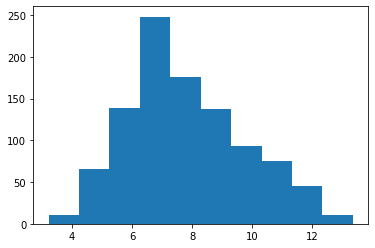

In [31]:
import numpy as np
from scipy.special import gamma, factorial
from matplotlib import pyplot as plt 

# Prior alpha = 7, beta = 1
# Start with a value of lambda given by 8.0 and compute the prior probability density of observing this value

def prior_prob_density(lam, alpha, beta):
     return(beta**(alpha) * lam**(alpha - 1) * np.exp(-beta*lam) / gamma(alpha))

def likelihood_density(data, lam):
    return(lam**(data) * np.exp(-lam)/ factorial(data))

# Starting value of lambda
lambda_current = 8.0
# Prior parameters alpha and beta
alpha = 7.0
beta = 1.0
# Observed data of 9 outages 
data_val = 9

lambda_array = np.zeros(1000)

for i in range(1000):
    
    # Current value 
    prior = prior_prob_density(lam=lambda_current, alpha=alpha, beta=beta)
    likelihood = likelihood_density(data=data_val, lam=lambda_current)
    posterior_current = likelihood * prior 
    
    # Proposed value
    lambda_proposed = np.random.normal(lambda_current, scale=0.5) # scale is our tuning parameter
    prior = prior_prob_density(lam=lambda_proposed, alpha=alpha, beta=beta)
    likelihood = likelihood_density(data=data_val, lam=lambda_proposed)
    posterior_proposed = likelihood * prior
    
    # Compute the probability of move
    ratio = posterior_proposed / posterior_current
    p_move = min(ratio, 1)
    random_draw = np.random.uniform(0,1)
    if (random_draw < p_move):
        lambda_current = lambda_proposed
        
    # Store the current value
    lambda_array[i] = lambda_current

plt.hist(lambda_array)

### UNGRADED EVALUATION (50 min)

#### 1. Run the simulation for 10 iterations and print out the following as a table, with each trial being a row

  a. the current parameter value and its hyperparameters

  b. proposed parameter value and its hyperparameters

  c. the posterior probabilities of both

  d. the probability of move

  e. the drawn random value

  f. the decision as a binary value


#### 2. Summarize the above distribution - Mean, Variance, Minimum and Maximum, Quartiles


### The Metropolis-Hastings Algorithm

#### Overview

One of the limitations of the Metropolis algorithm was the requirement of a symmetric proposal distribution. The Metropolis-Hastings algorithm relaxes this requirement by providing a correction term if a non-symmetric proposal distribution is used. This correction is applied to $p_{move}$ and is of the form

$p_{move} = min( \dfrac{P(\mu_{proposed} | data) \cdot g(\mu_{current} | \mu_{proposed})}{P(\mu_{current} | data) \cdot g(\mu_{proposed} | \mu_{current})}, 1)$

where the correction term is 

$\dfrac{g(\mu_{current} | \mu_{proposed})}{g(\mu_{proposed} | \mu_{current})}$

The term $g(\mu_{current} | \mu_{proposed})$ is the probability density of drawing $\mu_{current}$ from a normal distribution centered around $\mu_{proposed}$. The standard deviation for this normal distribution is the tuning parameter. For a symmetric proposal distribution such as a normal distribution the correction term would be 1 since the probability density of drawing $\mu_{current}$ from a Gaussian centered at $\mu_{proposal}$ only depends on the distance between $\mu_{current}$ and $\mu_{proposal}$ (standard deviation is a hyperparameter that is fixed). Similarly, the probability density of drawing $\mu_{proposal}$ from a Gaussian centered around $\mu_{current}$ depends only on the distance between these two values, which is the same as before. Hence the numerator and the denominator are the same which results in the correction factor being 1.

#### Why do we need a correction term?

The correction term exists to account for the lack of symmetry in a non-symmetric proposal distribution. The Metropolis algorithm is therefore a specific case of the Metropolis-Hastings algorithm. When distributions other than a Gaussian is used as a proposed distribution, one can center $\mu_{current}$ and  $\mu_{proposal}$ on the mean, median or mode of the distribution. It is also possible to draw samples from a fixed distribution, this technique is called the Independent Metropolis-Hastings sampling algorithm.

#### What is the advantage of using a non-symmetric proposal distribution?

If the parameter we are seeking is bounded in value, using a symmetric distribution can result in invalid draws. Also, since we are working in a Bayesian setting we want to take advantage of our prior knowledge of this parameter. If it is known that the parameter has a certain distribution, we should be able to incorporate this information into our sampling process.

### UNGRADED EVALUATION (2.5 hours)

#### 1. Write Python code to modify the Metropolis algorithm from above to make it a Metropolis-Hastings algorithm 

#### 2. Using the example of power outages above 

1. Run a simulation for 1000 iterations and summarize the above distribution - Mean, Variance, Minimum and Maximum, Quartiles

2. Run the simulation for 10 iterations and print out the following as a table, with each trial being a row

   a. the current parameter value and its hyperparameters

   b. proposed parameter value and its hyperparameters

   c. the posterior probabilities of both

   d. the correction factor

   e. the probability of move

   f. the drawn random value
   
   g. the decision as a binary value




### GRADED EVALUATION (30 mins)


1. The ratio of the transition probabilities between states can be seen as the ratio of their probability densities

    a. True

    b. False


2. Not using a reasonable prior can result in convergence issues when performing MCMC sampling

    a. True

    b. False 


3. Not using an appropriate proposal distribution during MCMC can result in inaccurate inferences about a parameter

    a. True

    b. False 


4. The Metropolis-Hastings algorithm differs from the Metropolis algorithm in terms of the correction term that is added to the Metropolis step

    a. True

    b. False 


5. The Metropolis algorithm is a specific case of the Metropolis-Hastings algorithm

   a. True

   b. False


6. Why does a correction term exist in the Metropolis-Hastings algorithm?

   a. To remove the errors introduced by the Metropolis algorithm

   b. To correct for the lack of symmetry in a non-symmetric proposal distribution


7. We use non-symmetric proposal distributions because

   a. They are more fun to use!

   b. To avoid invalid draws


8. In the Metropolis algorithm, what is used as the tuning parameter if a Normal distribution is used as a proposal distribution?

    a. Standard deviation
    
    b. Mean
    

9. Bayesian Inference can be seen as a type of online learning since

    a. The inferred posterior can be used as the prior when new data arrives 
    
    b. The prior can be reused again for new data
    
    
10. If the traceplot displays a straight line, this is a sign that

    a. The newly proposed values are being rejected
    
    b. The sampling has converged

### Gibbs Sampling

In a Gibbs sampler, the proposal distribution matches the posterior conditional distribution and as a result the  proposals are always accepted (since there is no reason to reject unlike in the Metropolis algorithm where an arbitrary proposal distribution is used). This can be seen as a specific case of a Metropolis algorithm. One of the features of the Gibbs sampler is that it allows us to perform inference on more than one parameter at a time. This is done by drawing one parameter at a time conditional on the values of the other parameters. It iteratively works through the parameters using this process and continues till sufficient samples have been drawn for all parameters.

Additionally, Gibbs Sampling can draw proposals from an asymmetric distribution. In the example below, we will be drawing from a Gamma distribution which is not symmetric. Not having a pre-determined proposal distribution is seen sometimes as an advantage. The disadvantage of this method, however, is that you are required to decompose the joint distribution into the conditional distributions in order to sample from them.  If the conjugate solutions are known, the Gibbs sampler can be faster than the Metropolis-Hastings algorithm.

In the following example, we are going to to try the infer the parameters of a Normal distribution, i.e. the mean given by \\(\mu\\) and the precision given by \\(\tau\\). We use a Normal distribution here since we can use that to illustrate how Gibbs sampling can be used to estimate multiple parameters, i.e. \\(\mu\\) and \\(\tau\\), at the same time. 


#### The Problem Setup

We are going to use Gibbs sampling to estimate the parameters of a model that is used to represent some phenomenon. For the sake of this exercise, let us say that this is a Normal distribution and we have one data point as our observation.

Since we are using a Normal distribution, parameterized as $N(\mu, \tau)$ we will need the conjugate solution for computing our posterior from the priors. Here $\mu$ is the mean and $\tau$ is the precision of the Normal distribution. A word on notation as we proceed, using $\tau$ as an example - the draws are denoted by numbered subscripts such as $\tau_0$, $\tau_1$ while the hyperparameters for the prior and posterior distributions are denoted as $\tau_{prior}$ and $\tau_{posterior}$ respectively. 

$$\mu \sim N(\mu_{prior}, \tau_{prior})$$

Select $\mu_{prior}$ to be 12 and $\tau_{prior}$ to be 0.0625 which corresponds to a $\sigma$ of 4.

$$\tau \sim Gamma(\alpha_{prior}, \beta_{prior})$$ 

Select the shape parameter $\alpha_{prior}$ to be 25 and the rate parameter $\beta_{prior}$ to be 0.5. 

##### Conjugate Solution for Parameter \\(\mu\\) with a Normal Prior

$$\mu_{posterior} = (\tau_{prior} \mu_{prior} + \tau_0 \sum_i x_i) / (\tau_{prior} + n \tau_0)$$

$$\tau_{posterior} = \tau_{prior} + n * \tau_0$$

##### Conjugate Solution for  Parameter \\(\tau\\) with a Gamma Prior

$$\alpha_{posterior} = \alpha_{prior} + n/2$$

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{1})^2 / 2$$


#### Outline of the Algorithm

1. Specify reasonable priors for the parameters $\mu$ and $\tau$.
2. Choose one parameter from the two parameters above to start with, and assign an initial value. Let us assume that we start with $\tau$ here and select a value of $\tau_0$ from the Gamma prior distribution.
3. Start our first trial. We want to obtain a sample for $\mu$ from the posterior distribution of $\mu$ given the value of $\tau_0$. This is where we use our knowledge of the distribution and use a conjugate solution to obtain the posterior distribution of $\mu$. Now we draw a sample $\mu_1$ from this posterior distribution.
4. We continue with trial 1 since we need to obtain a value for $\tau_1$ conditional on the value of $\mu_1$. Similar to step (3), we use the conjugate solution to obtain a posterior distribution of $\tau$ given a value of $\mu_1$. Draw a value of $\tau_1$ from this distribution.
5. We accept both values we have drawn in steps (3) and (4) and trial 1 is now complete. Note that unlike the Metropolis algorithm, we do not stochastically accept or reject the proposals, we accept all drawn values.
6. Repeat steps (3) to (5) till we have a sufficient number of samples. This process of iteratively updating the parameters is loosely akin to coordinate ascent for optimization.


#### The details

 
**Please don't confuse $\tau$, which is the parameter our Normal distribution, with $\tau_0$ which is the hyperparameter of our mean $\mu$.** 

We have one data point that we are going to use to illustrate how Gibbs sampling works.  Obviously, in a real example we will have multiple data points in which case we will have to compute the likelihood and posterior given all those data values. We will walk through the first two trials of Gibbs Sampling.                                            
##### The Algorithm

<hr style = "border:1px dotted salmon"></hr>

a. With the priors set up, draw a value for $\tau_0$ from the Gamma prior distribution. Let us assume that this is 40.123.

<hr style = "border:1px dotted salmon"></hr>

b. Start trial 1. Calculate the posterior distribution of $\mu$ (Normal distribution) using the conjugate solution shown below. Here 'n' is the number of samples which happens to be 1 for our example.

$$\mu_{posterior} =(\tau_{prior} \mu_{prior} + \tau_0 \sum_i x_i) / (\tau_{prior} + n \tau_0)$$ 
$$= (0.0625 * 12 + 40.123 * 10.2) / (0.0625 + 1 * 40.123) = 10.2028$$
$$\tau_{posterior} = \tau_{prior} + n * \tau_0  = 0.0625 + 1 * 40.123 = 40.1855$$

c. Draw a value for $\mu_1$ from this computed posterior distribution for $\mu$ from step (b). Let us assume that this value of $\mu_1$ is <mark>10.5678</mark>.

d. With the given value of $\mu_1$, we now compute the posterior distribution of $\tau$ using a conjugate solution for the Gamma distribution. 

$$\alpha_{posterior} = \alpha_{prior} + n/2 = 25 + 1/2 = 25.5$$

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{1})^2 / 2 = 0.5 + (10.2 - 10.5678)^2 / 2 = 0.5676$$

e. Draw a value for $\tau_1$ from this posterior distribution computed in step (d). Let us assume that this value is <mark>45.678</mark>. Trial 1 is now complete.

<hr style = "border:1px dotted salmon"></hr>

f. Trial 2 will be similar to trial 1 except that we substitute the values for $\tau_0$ and $\mu_0$ with the updates $\tau_1$ and $\mu_1$ we obtained at the end of steps (c) and (e).

g. Update the posterior for $\mu$

$$\mu_{posterior} =(\tau_{prior} \mu_{prior} + \tau_1 \sum_i x_i) / (\tau_{prior} + n \tau_1) = (0.0625 * 12 + 45.678 * 10.2) / (0.0625 + 1 * 45.678) = 10.2025$$

$$\tau_{posterior} = \tau_{prior} + n * \tau_1  = 0.0625 + 1 * 45.678 = 45.7405$$

h. Draw a sample from this updated posterior as $\mu_2$. Let us assume that this is <mark>10.0266</mark>

i. Update the posterior for $\tau$. Note that the value of \\(\alpha_{posterior}\\) does not change.

$$\alpha_{posterior} = \alpha_{prior} + n/2 = 25 + 1/2 = 25.5$$ 

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{2})^2 / 2 = 0.5 + (10.2 - 10.0266)^2 / 2 = 0.5150$$

j. Draw a sample from this posterior distribution as $\tau_2$. Trial 2 is now complete.

k. By now you must have a sense of this process. If not,we simply repeat steps (f)
 to (j) till we have a sufficient number of samples.

<hr style = "border:1px dotted salmon"></hr>

#### Building the Inferred Distribution

Use the current values that we obtain at each step for both $\mu$ and $\tau$, and build a frequency distribution (histogram) from it. We can also create a joint distribution as well using a two-dimensional histogram.

### UNGRADED EVALUATION (2 hours)

#### 1. Use the Metropolis Python code as boilerplate code to perform Gibbs Sampling

#### 2. Using the parameter values from the example above 

1. Run a simulation for 1000 iterations. 

2. Run the simulation for 10 iterations annd print out the following as a table, each row representing a trial

   a. the posterior parameter values for both $\mu$ and $\tau$ at each trial

   b. sampled parameter values $\mu$ and $\tau$ at each trial

#### 3. Summarize the above distribution - Mean, Variance, Minimum and Maximum, Quartiles

#### 4. Plot the joint distribution of the two parameters.


### Hamiltonian Monte Carlo (also called Hybrid Monte Carlo)

The best resource on the topic! - 

[Betancourt Youtube Video](https://www.youtube.com/watch?v=VnNdhsm0rJQ)

[![Betancourt Youtube Video](https://statmodeling.stat.columbia.edu/wp-content/uploads/2016/06/Screen-Shot-2016-06-10-at-5.29.51-PM.png)](https://www.youtube.com/watch?v=VnNdhsm0rJQ "Betancourt")

[Stan page on HMC](https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html)

[Wikipedia Reference](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)


We won't go into a lot of detail of HMC here since this is quite conceptually involved. 
This is based on the solution of differential equations known as Hamilton's equations for the motion of a particle in space. This relates the position of the particle \\(x\\), the momentum \\(m\\) and the Hamiltonian $H$ through the following equations 

$$\dfrac{dx}{dt} = \dfrac{dH}{dm}$$

$$\dfrac{dm}{dt} = - \dfrac{dH}{dx}$$


These differential equations depend on the probability distributions we are trying to learn. We navigate these distributions by moving around them in a trajectory using steps that are defined by the position and momentum at that position. Like in many algorithms, the momentum term allows the particle to move up a posterior space, as opposed to always moving down. The steps that we take also depend on the curvature of the posterior. Navigating these trajectories can be a very expensive process and the goal is to minimize this computational process.

HMC is based on the notion of conservation of energy. The Hamiltonian is intuitively the sum of the kinetic and potential energy of the particle, or in simple terms it measures the total energy of the system. 

$$H(x,m) = U(x) + KE(m)$$

where \\(U(x)\\) is the potential energy of the system and \\(KE(m)\\) is the kinetic energy of the system. The potential energy is measured using the negative log density of the posterior distribution.  When the sampler trajectory is far away from the probability mass center, it has high potential energy but low kinetic energy. When the trajectory is closer to the center of the probability mass it will have high kinetic energy but low potential energy. The kinetic energy term (momentum) involves a mass matrix \\(\Sigma\\) that is also the covariance of the normal distribution from which we randomly draw a momentum value \\(m\\) in our Monte Carlo process. An outline of the steps involved in this algorithm is given below.

##### Outline 

* We start from an initial position \\(x_0\\). 

* At each step, we select a random value for momentum from a proposal distribution. This is usually a normal distribution such that

$$m \sim N(\mu, \Sigma)$$

* From the current position and using the sampled value for momentum, we run the particle for time $L \cdot \Delta t$ using a leapfrog integrator which is a numerical integration scheme to march forward in time. The terms $\Delta t$ refers to the time step taken for the integrator, and $L$ refers to the total number of steps taken. $L$ is a hyperparameter that needs to be tuned carefully. If we are at a spatial location indicated by step \\(n\\), we start from time 0 (integration time) and integrate till time \\(t\\) to get the following

$$x_n(0) \longrightarrow x_n(L \Delta t)$$

$$m_n(0) \longrightarrow m_n(L \Delta t)$$

* The leapfrog integration introduces errors due to the fact that it is a numerical integration method and not an exact integral. This is corrected using a Metropolis-Hastings step that probabilistically accepts the new values of $x_{n+1}$ as $x_n(L \cdot \Delta t)$ or the original location $x_n(0)$. The acceptance probability used here is given below. Here \\(p(x_n(L \cdot \Delta t))\\) corresponds to the posterior probability density at the end of the integration scheme and \\(p(x_n(0))\\) coresponds to the posterior probability density at the beginning of the integration scheme. Also, \\(q(m)\\) is the probability density of the proposal distribution for the momentum. 

$$ acceptance \; rate = \dfrac{p(x_n(L \cdot \Delta t))}{p(x_n(0))} \times \dfrac{q(m(L \cdot \Delta t))}{q(m(0))}$$

* Draw a random value \\(u\\) from a uniform distribution \\(U[0,1]\\). If \\(r > u\\), move to the location \\(x_n(L \cdot \Delta t)\\) otherwise remain at location \\(x_n(0)\\).

* Record the new position \\(x_{n+1}\\). This is repeated for 'n' or a number of spatial steps. 


##### Impact of \\(T\\) in HMC

Now \\(T\\) can be defined such that

$$T = L \cdot \Delta t$$

When there are divergences the sampling process that happens in regions of high curvature, we might have to resort to smaller values of \\(\Delta t\\).

The use of larger than desirable values for \\(T = L \cdot \Delta t\\) results in the sampler making U-turns at locations of high curvature in the posterior space. This can be wasteful since the sampler then ends up wasting time retracing its steps. One way to mitigate this is through a preliminary run of tuning samples to heuristically select values of  \\(T\\) that work better.

A No U-Turn sampler (NUTS) is an extension of the HMC where the number of steps of the integrator $L$ and therefore \\(T\\) is automatically tuned. For regions of high curvature a smaller value of \\(T\\) is used so as to minimize U-turns whereas for flatter regions, a larger \\(T\\) is used to move faster. Therefore an adaptive \\(T\\) is used that is locally optimal as opposed to a single value of \\(T\\). Even though we don't know what the posterior looks like (since this is what we are inferring and therefore we can't evaluate its curvature), the NUTS algorithm has ways to estimate it.

NUTS uses a scaling matrix that defines the shape of the sampling distribution through the covariance matrix so that the jumps are bounded in all directions. Poor choice of this scaling matrix can result in the sampling stopping or stalling. Fortunately, tools such as PyMC3 can automatically determine appropriate parameter values during the tuning phase.


### Properties of MCMC

#### Representativeness

The samples from the MCMC process should be representative of the posterior distribution, it should cover the distribution space thoroughly. The final state of the inferred distribution should be independent of the initial value.

There are two ways to measure if your inferred distribution is representative of the true distribution: 

1. Visual inspection using a trace for convergence

2. Numerical measures for convergence

The trace is simply the plot of the sample value on the y-axis against the iteration number, when it is sampled, on the x-axis. The first 'n' samples are discarded because the sampling process is moving around in space trying to find the regions of representative posterior density. These 'n' samples are called the burn-in and the samples are usually discarded. The choice of 'n' depends on the distribution but usually around 500 is selected to be an adequate number of samples. As shown below, there is good overlap between the samples from the different chains as indicated by the trace and the density plots.

Numerical measures include the Gelman-Rubin statistic (also called the potential scale reduction factor or the shrink factor). This measures the ratio of the variance of the samples among the chains to the variance within the chains. A number greater than 1 usually indicates a lack of convergence.

![Trace plot](https://srijithr.gitlab.io/image-20201207170920197.png)

<center> Trace plot </center>

#### Accurate

The samples should be sufficiently large such that the estimates are stable. For this reason, separate 'chains' of samples are run to ensure consistency of results. If the chains vary a lot, as seen by inspecting a histogram or a density plot of the samples, the samples are deemed to not be stable and this requires further investigation. Autocorrelation is a common issue where samples that are drawn are not completely independent of each other. An effective sample size is calculated that gives you the true number of samples that are useful for constructing a distribution.

Another measure of accuracy is the Monte Carlo Standard Error (MCSE). If we draw 4 chains, chances are that the sample mean each time will differ from each other and the true mean. The MCSE is simply the standard error of this computed mean. The larger the sample size, the less the MCSE will be.

#### Efficiency

The samples spanning the distribution should be generated efficiently such that sharper regions are resolved appropriately. There is quite a bit of difference in runtimes between the least and the most efficient MCMC algorithms. For more complex models where the dimensionality of the parameters increase, vanilla Metropolis algorithms can be downright impractical.

Run multiple chains in parallel as much as possible since each chain is an embarassingly parallel task. Knowledge of the problem at hand helps one to pick the right sampling algorithm, resulting in more efficient sampling. 

##### Mean-center the data

It is advantageous to mean-center the data before performing MCMC sampling. The example below of linear regression helps to illustrate this. The figure below is a 1-dimensional linear regression problem given by

$$ y = \alpha x + \beta $$

and the class of regression lines along with the associated uncertainty is reflected by the spread of these lines. Here \\(\alpha\\) is the slope of the line and \\(\beta\\) is the y-intercept. The lines pass around the mean of the x and y values of the data and rotate around this 'pivot point'. For each line, as the slope increases, the y-intercept decreases and vice-versa. Hence there is a strong correlation between these coefficients.

![Regression lines](https://courseraimages.s3-us-west-2.amazonaws.com/family_regression.png)

<center> Family of Regression lines </center>

The figure beneath illustates this correlation between the coefficients of linear regression \\(\alpha\\) and \\(\beta\\). The distribution space represented there has a very narrow diagonal shape which is not ideal for sampling. If you think about the example of Gibbs sampling, you select one parameter \\(\alpha\\) and then search for the other parameter \\(\beta\\) by moving along the line parallel to the y axis located at that value of \\(\alpha\\). This has a limited range because of this narrow shape of the parameter space as indicated by the correlation plot. Convergence, as a result, can take a long time. 

When you mean-center the data, you subtract the mean of x from all the values which results in the x values being centered around zero. The pivot point (not exactly at the mean but close to it) is now almost over zero on the x axis which means that the y-intercept does not change much. This breaks the correlation between the two coordinates making it easier to sample.

![Inverse correlation](https://courseraimages.s3-us-west-2.amazonaws.com/inverse_correlation.png)

<center> Inverse correlation of the intercepts </center>

### GRADED EVALUATION (30 mins)


1. In a Gibbs Sampler, the proposals are always accepted

    a. True
    
    b. False 


2. A Gibbs Sampler is a specific case of a Metropolis algorithm

    a. True
    
    b. False
    
    
3. Gibbs sampler samples from one parameter at a time, cycling through one parameter at a time.

    a. True
    
    b. False 
    
    
4. In Gibbs sampling, the proposal distribution is 

    a. A Normal distribution
    
    b. The posterior conditional distribution
    
    
5. We visually inspect the trace to

    a. Check for convergence
    
    b. Determine the largest sampled value
    

6. We can use a histogram to look at the distribution of the posterior from Metropolis, Metropolis-Hastings or Gibbs sampling

   a. True

   b. False 


7. HMC is based on the motion of a particle in space 

   a. True

   b. False


8. In HMC, a numerical integration step is performed at each step to march forward and obtain the solution

   a. True

   b. False


9. The reason for a Metropolis-Hastings step when performing HMC is to

   a. Make HMC run faster

   b. Correct the errors from the numerical integration scheme 


10. When using NUTS, the number of steps 'L' is automatically tuned

   a. True

   b. False 